<a href="https://colab.research.google.com/github/IbrahimAllMamun/time_series_analysis/blob/main/Shipon_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from lightgbm import LGBMRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df_full = pd.read_csv('data.csv')

qt = QuantileTransformer(output_distribution='normal')
qt.fit_transform(df_full[['radiation']])

df_full['timestamp'] = pd.to_datetime(df_full['timestamp'])
df_full['timestamp'] = df_full['timestamp'].dt.tz_localize(None)

df_fore = df_full[df_full['year'] == 24]
df = df_full[df_full['year'] != 24]

In [65]:
def model_eval(data, title):
    plt.figure(figsize=(12, 5))
    plt.plot(data['actual_radiation'], label='Actual', linewidth=2)
    plt.plot(data['pred_radiation'], label='Forecasted', linestyle='--')
    plt.title(f"Actual vs Forecasted Radiation ({title})")
    plt.xlabel("Time")
    plt.ylabel("Radiation")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"train_test_{title}.pdf", format = "pdf")
    plt.show()

    data_new = data.dropna()
    y_test = data_new['actual_radiation']
    y_pred = data_new['pred_radiation']
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return rmse, mae, r2, mape

<ipython-input-4-6ed7b00337bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['timestamp_numeric'] = pd.to_numeric(subset['timestamp']) / 10**9 # Convert to seconds
<ipython-input-4-6ed7b00337bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['timestamp_numeric'] = pd.to_numeric(subset['timestamp']) / 10**9 # Convert to seconds
<ipython-input-4-6ed7b00337bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

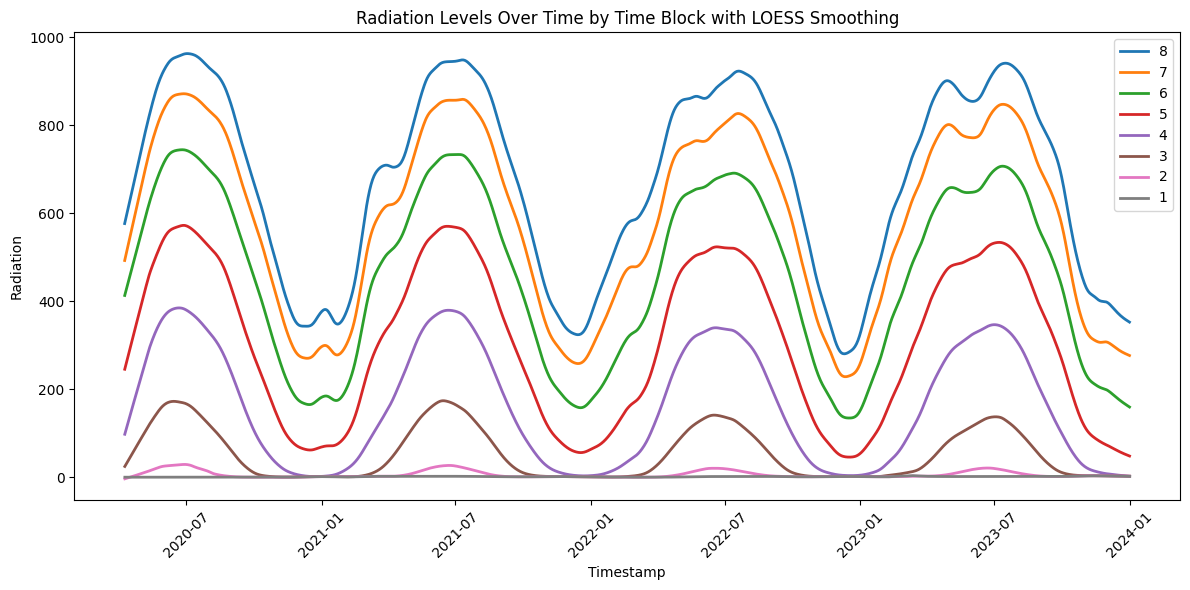

In [4]:
plt.figure(figsize=(12, 6))
# Create handles and labels for legend
handles, labels = [], []

for time_block in df['time_block'].unique():
    subset = df[df['time_block'] == time_block]
    # Convert timestamp to numeric representation for loess
    subset['timestamp_numeric'] = pd.to_numeric(subset['timestamp']) / 10**9 # Convert to seconds

    # Fit LOESS
    loess_smoothed = lowess(subset['radiation'], subset['timestamp_numeric'], frac=0.05)

    # Scatter plot and LOESS line
    line, = plt.plot(subset['timestamp'], loess_smoothed[:, 1], linestyle='-', linewidth=2)

    # Append handles and labels for legend
    handles.extend([line])  # Add scatter and line to handles
    labels.extend([time_block])  # Add labels with 'LOESS' for clarity

# Place legend outside the loop
plt.legend(handles, labels)

plt.xlabel('Timestamp')
plt.ylabel('Radiation')
plt.title('Radiation Levels Over Time by Time Block with LOESS Smoothing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("time_block.jpg", format = "jpg")
plt.show()

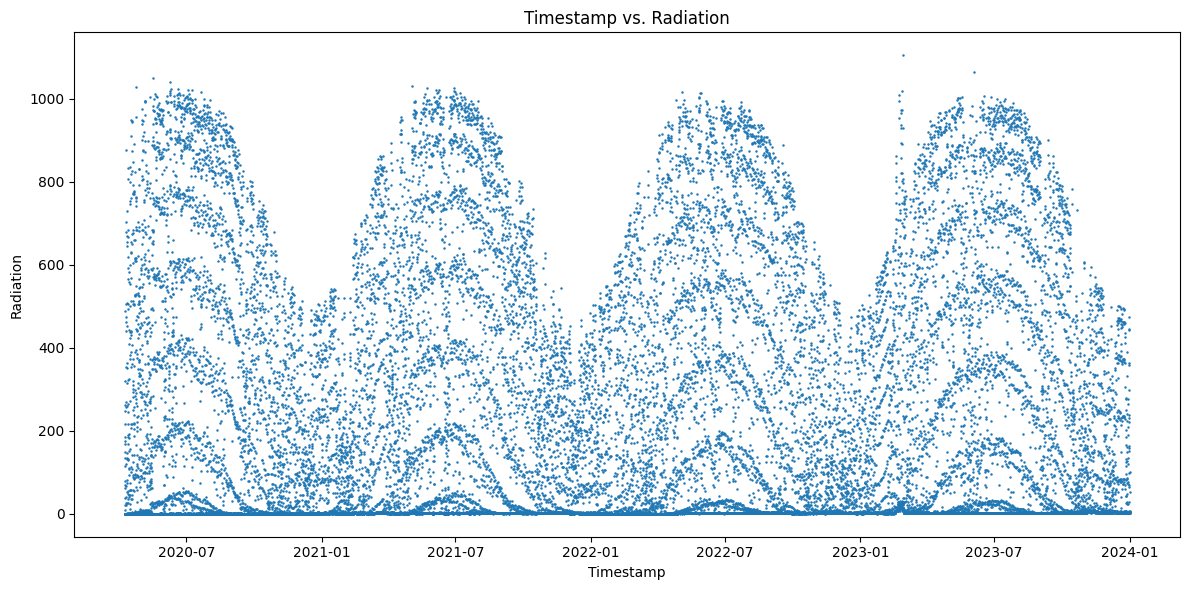

In [5]:
plt.figure(figsize=(12, 6))
plt.scatter(df['timestamp'], df['radiation'], alpha=1, s=0.6)  # Adjust alpha for transparency
plt.xlabel('Timestamp')
plt.ylabel('Radiation')
plt.title('Timestamp vs. Radiation')
plt.tight_layout()
plt.savefig("original_data.jpg", format = "jpg")
plt.show()

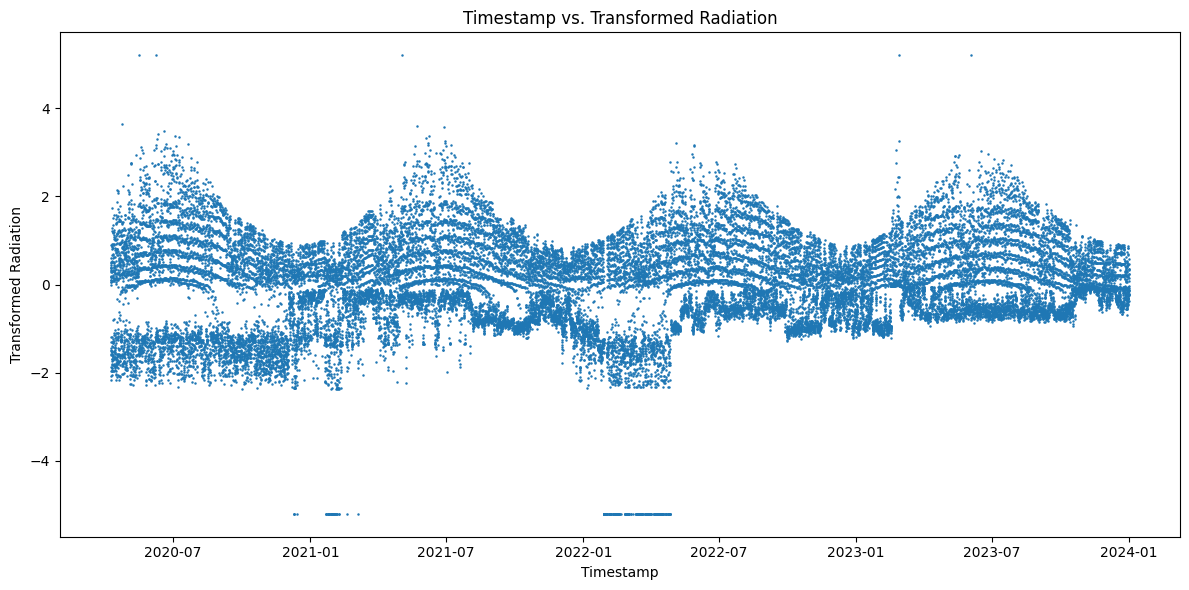

In [6]:
plt.figure(figsize=(12, 6))
plt.scatter(df['timestamp'], df['radiation_log'], alpha=1, s=0.6)  # Adjust alpha for transparency
plt.xlabel('Timestamp')
plt.ylabel('Transformed Radiation')
plt.title('Timestamp vs. Transformed Radiation')
plt.tight_layout()
plt.savefig("transformed_data.jpg", format = "jpg")
plt.show()

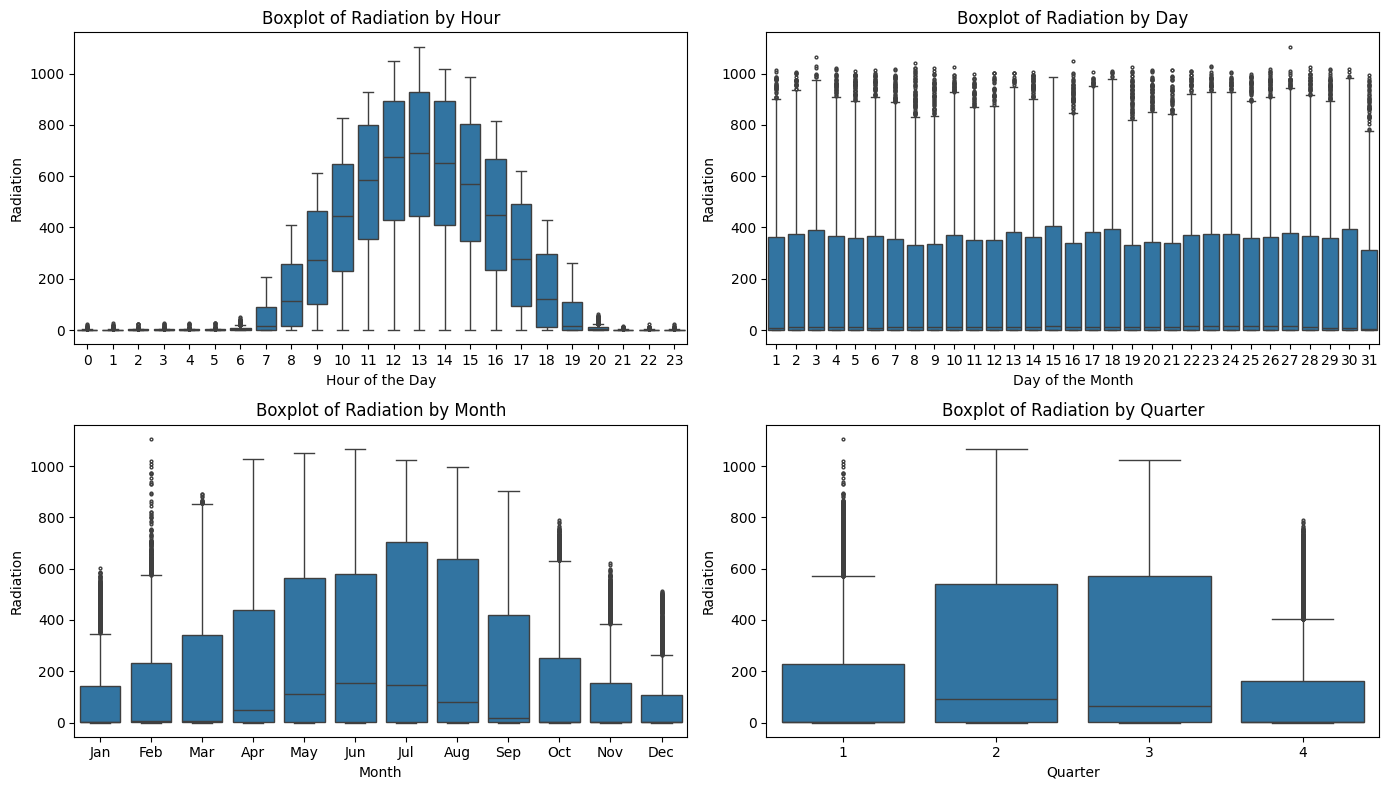

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
sns.boxplot(x='hour', y='radiation', data=df, ax=axes[0, 0], flierprops={"marker": ".", "markersize": 4})
axes[0, 0].set_xlabel('Hour of the Day')
axes[0, 0].set_ylabel('Radiation')
axes[0, 0].set_title('Boxplot of Radiation by Hour')

sns.boxplot(x='day', y='radiation', data=df, ax=axes[0, 1], flierprops={"marker": ".", "markersize": 4})
axes[0, 1].set_xlabel('Day of the Month')
axes[0, 1].set_ylabel('Radiation')
axes[0, 1].set_title('Boxplot of Radiation by Day')

sns.boxplot(x='month', y='radiation', data=df, ax=axes[1, 0], flierprops={"marker": ".", "markersize": 4})
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Radiation')
axes[1, 0].set_title('Boxplot of Radiation by Month')

month_labels = [calendar.month_abbr[i] for i in sorted(df['month'].unique())]
axes[1, 0].set_xticklabels(month_labels)

sns.boxplot(x='quarter', y='radiation', data=df, ax=axes[1, 1], flierprops={"marker": ".", "markersize": 4})
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Radiation')
axes[1, 1].set_title('Boxplot of Radiation by Quarter')

plt.tight_layout()
plt.savefig("boxplot.pdf", format = "pdf")
plt.show()


# SARIMAX

## ACF and PACF Plot

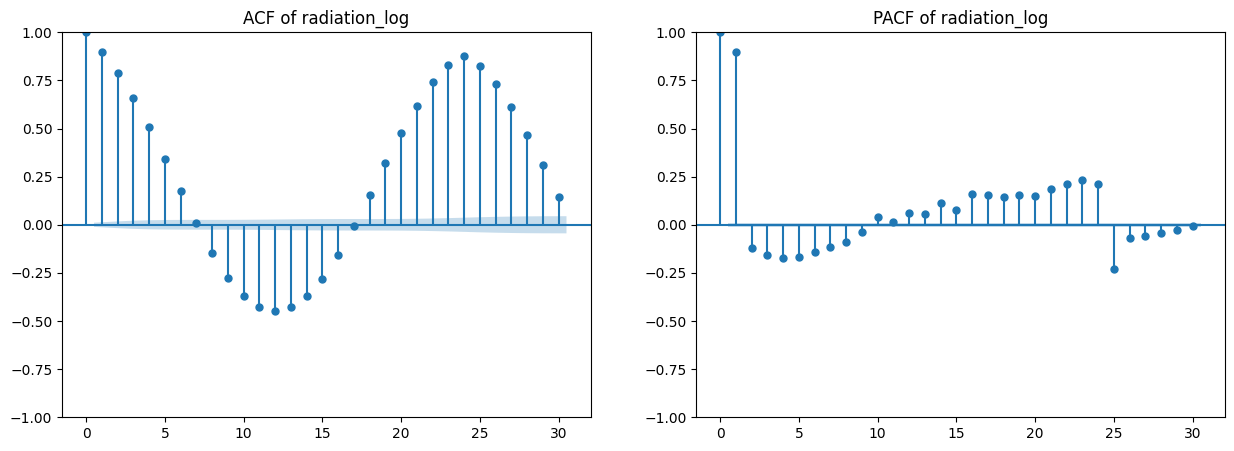

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df['radiation_log'], lags=30, ax=axes[0])
axes[0].set_title('ACF of radiation_log')

plot_pacf(df['radiation_log'], lags=30, ax=axes[1])
axes[1].set_title('PACF of radiation_log')

plt.savefig("acf_pacf.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [69]:
result = adfuller(df['radiation'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")


ADF Statistic: -6.632927
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Series is stationary


## Model Fit: (Train-Test)

In [8]:
features = ["time_block",
            "sin_hour",
            "cos_hour",
            "sin_quarter",
            "cos_quarter",
            "lag_1",
            "rolling_mean_24"]
df = df.dropna()
X = df[features]
X = X.astype(float)
y = df['radiation_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
y_test = qt.inverse_transform(y_test.values.reshape(-1, 1))

data = pd.DataFrame({'timestamp': df['timestamp'].values, 'actual_radiation': df['radiation'].values})
data.set_index('timestamp', inplace=True)

In [5]:
sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 0, 1),
    seasonal_order=(2, 0, 2, 24)
)
sarimax_train = sarimax_model.fit()
sarimax_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                           radiation_log   No. Observations:                26157
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood              -11241.707
Date:                                 Fri, 02 May 2025   AIC                          22511.413
Time:                                         18:12:22   BIC                          22625.819
Sample:                                              0   HQIC                         22548.363
                                               - 26157                                         
Covariance Type:                                   opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
time_block         -0.0933      0.016     -5.666      0.000      -0.126      -0.061
sin_hour           -0.3001      0.047     -6.350      0.000      -0.393      -0.207
cos_hour           -1.2600      0.060    -20.958      0.000      -1.378      -1.142
sin_quarter        -0.1114      0.045     -2.484      0.013      -0.199      -0.024
cos_quarter        -0.0377      0.044     -0.851      0.395      -0.124       0.049
lag_1               0.0005   4.66e-05     10.827      0.000       0.000       0.001
rolling_mean_24     0.0017      0.000     11.893      0.000       0.001       0.002
ar.L1               0.7963      0.002    361.072      0.000       0.792       0.801
ma.L1              -0.2462      0.003    -85.122      0.000      -0.252      -0.241
ar.S.L24            0.3014      0.161      1.878      0.060      -0.013       0.616
ar.S.L48            0.6473      0.156      4.156      0.000       0.342       0.953
ma.S.L24           -0.1847      0.161     -1.146      0.252      -0.501       0.131
ma.S.L48           -0.5600      0.137     -4.082      0.000      -0.829      -0.291
sigma2              0.1394      0.000    392.380      0.000       0.139       0.140
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):           1777047.96
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -2.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

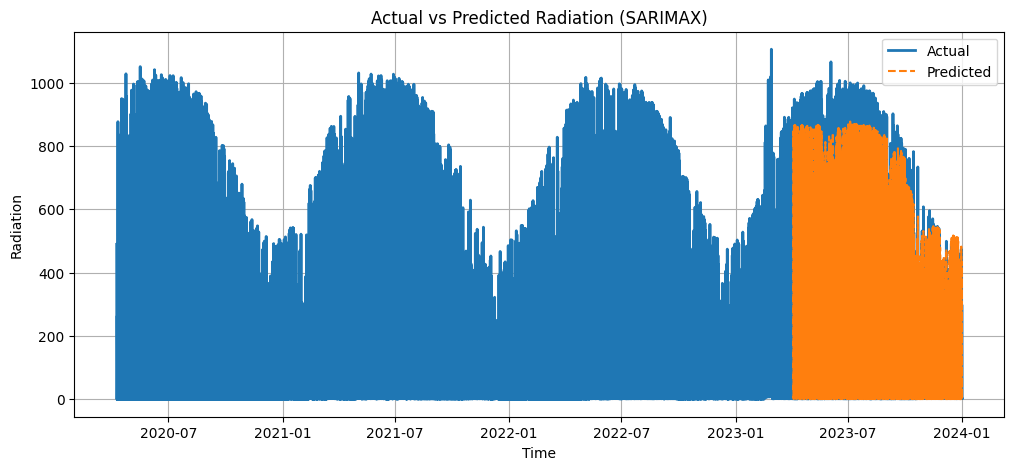


RMSE: 78.64
MAE: 46.06
R² Score: 0.93
MAPE: 0.81


In [95]:
y_pred_sar = sarimax_train.predict(start=len(y_train), end=len(y) - 1, exog=X_test)
y_pred_sar = qt.inverse_transform(y_pred_sar.values.reshape(-1, 1))

# Evaluate the best model
data['pred_radiation'] = np.nan
data.iloc[len(y_train):,1] = y_pred_sar
rmse, mae, r2, mape = model_eval(data, "SARIMAX")
print()

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}")

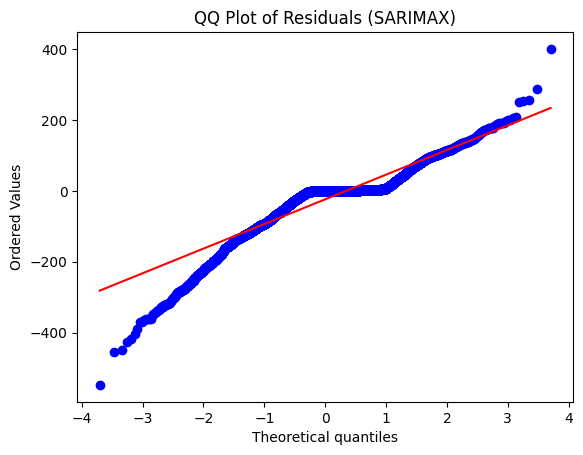

In [24]:
residuals = y_test.values - y_pred_sar.flatten()

# Create the QQ plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (SARIMAX)")
plt.savefig("QQ.jpg", format = "jpg")
plt.show()

## Fitting in the full data and forecasting

In [71]:
X_fore = df_fore[features]
y_act = df_fore['radiation']

data = pd.DataFrame({'timestamp': df_full['timestamp'].values, 'actual_radiation': df_full['radiation'].values})
data.set_index('timestamp', inplace=True)
data['pred_radiation'] = np.nan

In [10]:
sarimax_model = SARIMAX(
    y,
    exog=X,
    order=(1, 0, 1),
    seasonal_order=(2, 0, 2, 24)
)
sarimax_full = sarimax_model.fit()
sarimax_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                           radiation_log   No. Observations:                32697
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood              -11112.344
Date:                                 Sat, 03 May 2025   AIC                          22252.688
Time:                                         04:33:34   BIC                          22370.219
Sample:                                              0   HQIC                         22290.245
                                               - 32697                                         
Covariance Type:                                   opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
time_block         -0.0872      0.011     -7.725      0.000      -0.109      -0.065
sin_hour           -0.2419      0.033     -7.373      0.000      -0.306      -0.178
cos_hour           -1.1224      0.042    -26.587      0.000      -1.205      -1.040
sin_quarter        -0.1142      0.033     -3.468      0.001      -0.179      -0.050
cos_quarter        -0.0294      0.032     -0.909      0.363      -0.093       0.034
lag_1               0.0006   3.44e-05     16.852      0.000       0.001       0.001
rolling_mean_24     0.0016      0.000     14.049      0.000       0.001       0.002
ar.L1               0.7919      0.002    442.826      0.000       0.788       0.795
ma.L1              -0.2595      0.002   -108.992      0.000      -0.264      -0.255
ar.S.L24            0.3479      0.096      3.631      0.000       0.160       0.536
ar.S.L48            0.5913      0.092      6.427      0.000       0.411       0.772
ma.S.L24           -0.2110      0.095     -2.214      0.027      -0.398      -0.024
ma.S.L48           -0.5212      0.079     -6.610      0.000      -0.676      -0.367
sigma2              0.1133      0.000    488.100      0.000       0.113       0.114
===================================================================================
Ljung-Box (L1) (Q):                  15.79   Jarque-Bera (JB):           3033900.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

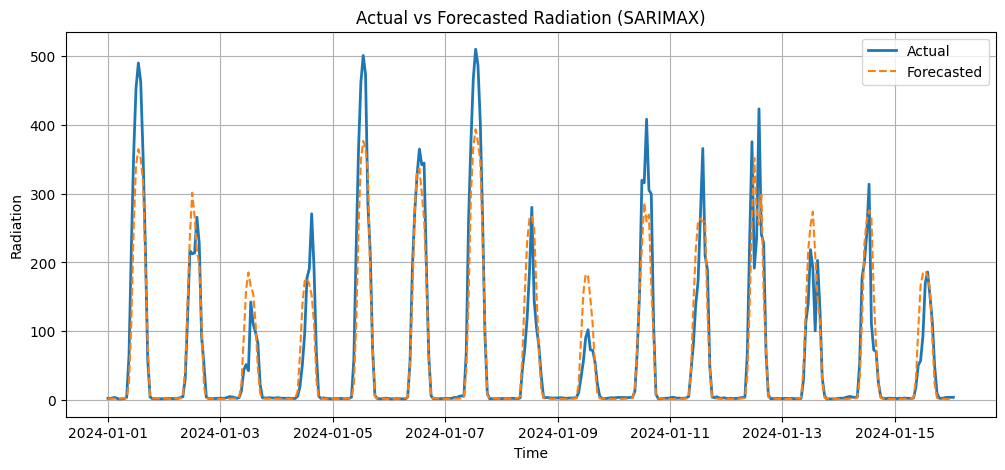


RMSE: 42.12
MAE: 20.72
R² Score: 0.87
MAPE: 0.36


In [66]:
y_pred_sarf = sarimax_full.predict(start=len(y), end=len(df_full['radiation_log']) - 1, exog=X_fore)
y_pred_sarf = qt.inverse_transform(y_pred_sarf.values.reshape(-1, 1))

data.iloc[len(y):,1] = y_pred_sarf
rmse, mae, r2, mape = model_eval(data.iloc[len(y):], "SARIMAX")
print("")

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}")


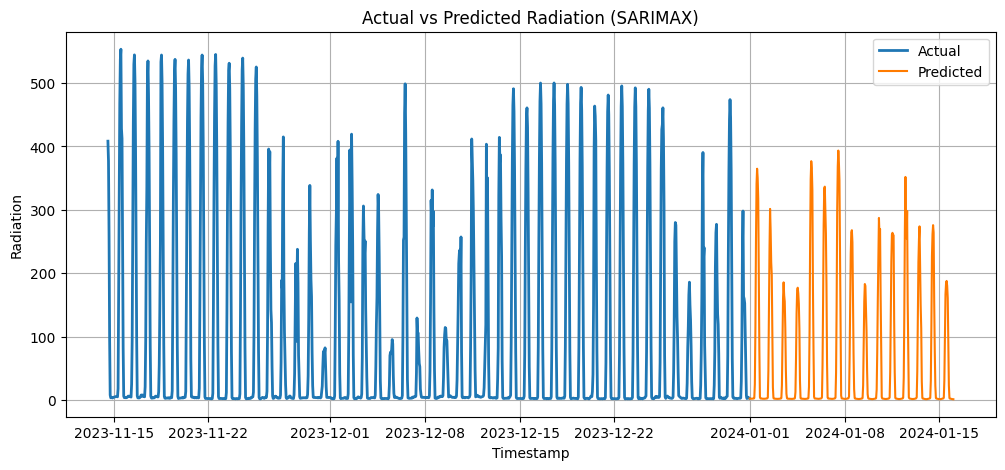

In [24]:
# y_pred_sarf = sarimax_full.predict(start=len(y), end=len(df_full['radiation_log']) - 1, exog=X_fore)
y_pred_sarf = sarimax_full.predict(start=len(y), end=len(df_full['radiation_log']) - 1, exog=X_fore)
y_pred_sarf = qt.inverse_transform(y_pred_sarf.values.reshape(-1, 1))


data_com = pd.DataFrame({'timestamp': df_full['timestamp'].values})
data_com['actual_radiation'] = np.nan
data_com.set_index('timestamp', inplace=True)
data_com.iloc[:len(y),0] = df['radiation'].values

data_com['pred_radiation_sar'] = np.nan
data_com.iloc[len(y):,1] = y_pred_sarf

n = 1500
plt.figure(figsize=(12, 5))
plt.plot(data_com['actual_radiation'].tail(n), label='Actual', linewidth=2)
plt.plot(data_com['pred_radiation_sar'].tail(n), label='Predicted', color='#ff7b00')
plt.title(f"Actual vs Predicted Radiation (SARIMAX)")
plt.xlabel("Timestamp")
plt.ylabel("Radiation")
plt.legend()
plt.grid(True)
plt.savefig("final_pred_sarimax.pdf", format = "pdf")
plt.show()


# LightGBM

## Train-Test evaluation

In [73]:
features = ["time_block",
            "sin_hour",
            "cos_hour",
            "sin_quarter",
            "cos_quarter",
            "lag_1",
            "rolling_mean_24"]
df = df.dropna()
X = df[features]
y = df['radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
y_test.index = df['timestamp'].iloc[len(y_train):].values

data = pd.DataFrame({'timestamp': df['timestamp'].values, 'actual_radiation': df['radiation'].values})
data.set_index('timestamp', inplace=True)

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 100]
}

model = LGBMRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

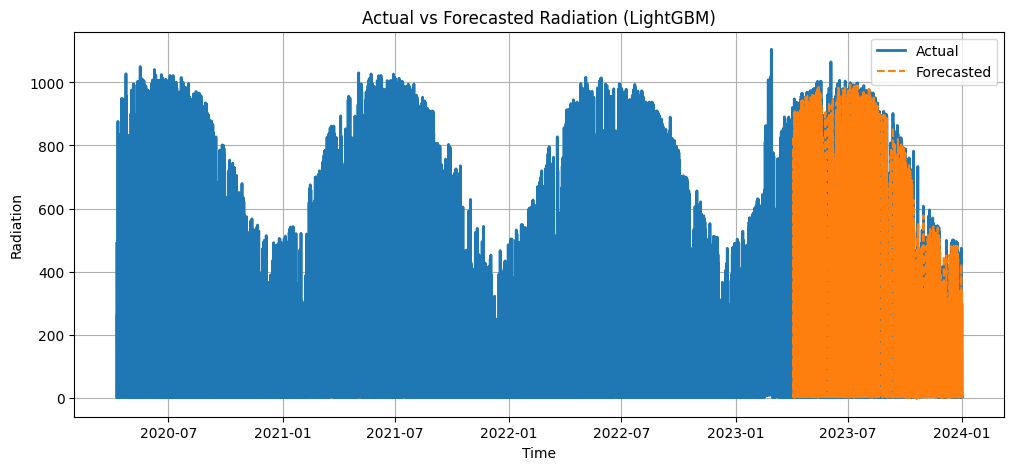


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}

RMSE: 47.33
MAE: 20.74
R² Score: 0.98
MAPE: 0.33

           Feature  Importance
5            lag_1         896
6  rolling_mean_24         712
1         sin_hour         270
0       time_block         264
2         cos_hour         186
4      cos_quarter         165
3      sin_quarter         109


In [74]:
best_model = grid_search.best_estimator_

# Evaluate the best model
data['pred_radiation'] = np.nan
data.iloc[len(y_train):,1] = best_model.predict(X_test)
rmse, mae, r2, mape = model_eval(data, "LightGBM")
print("")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print("")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}")
print("")
# Feature Importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

## Fitting in the full data and forecasting

In [18]:
X_fore = df_fore[features]
y_act = df_fore['radiation']

data = pd.DataFrame({'timestamp': df_full['timestamp'].values, 'actual_radiation': df_full['radiation'].values})
data.set_index('timestamp', inplace=True)
data['pred_radiation'] = np.nan

In [54]:
best_model = LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31)

In [ ]:
best_model.fit(X, y)

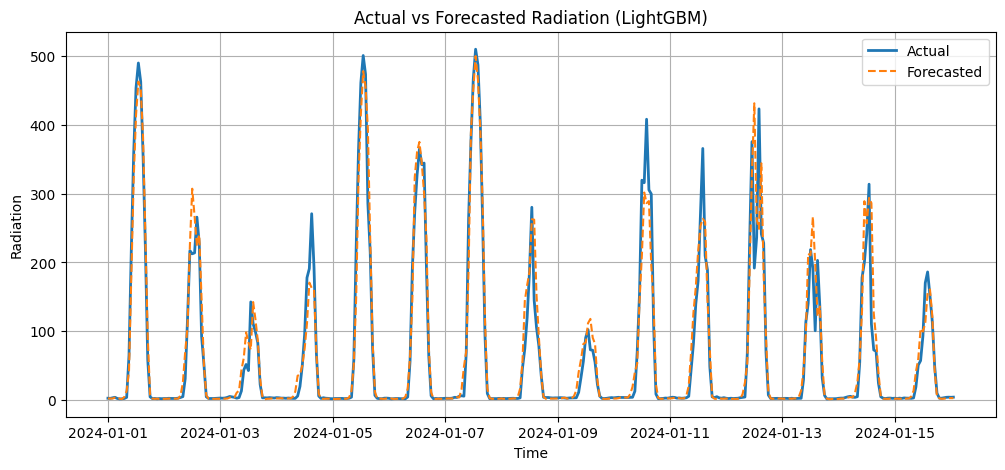


RMSE: 32.32
MAE: 15.10
R² Score: 0.92
MAPE: 0.51


In [67]:
data.iloc[len(y):,1] = best_model.predict(X_fore)
rmse, mae, r2, mape = model_eval(data.iloc[len(y):], "LightGBM")
print("")

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}")


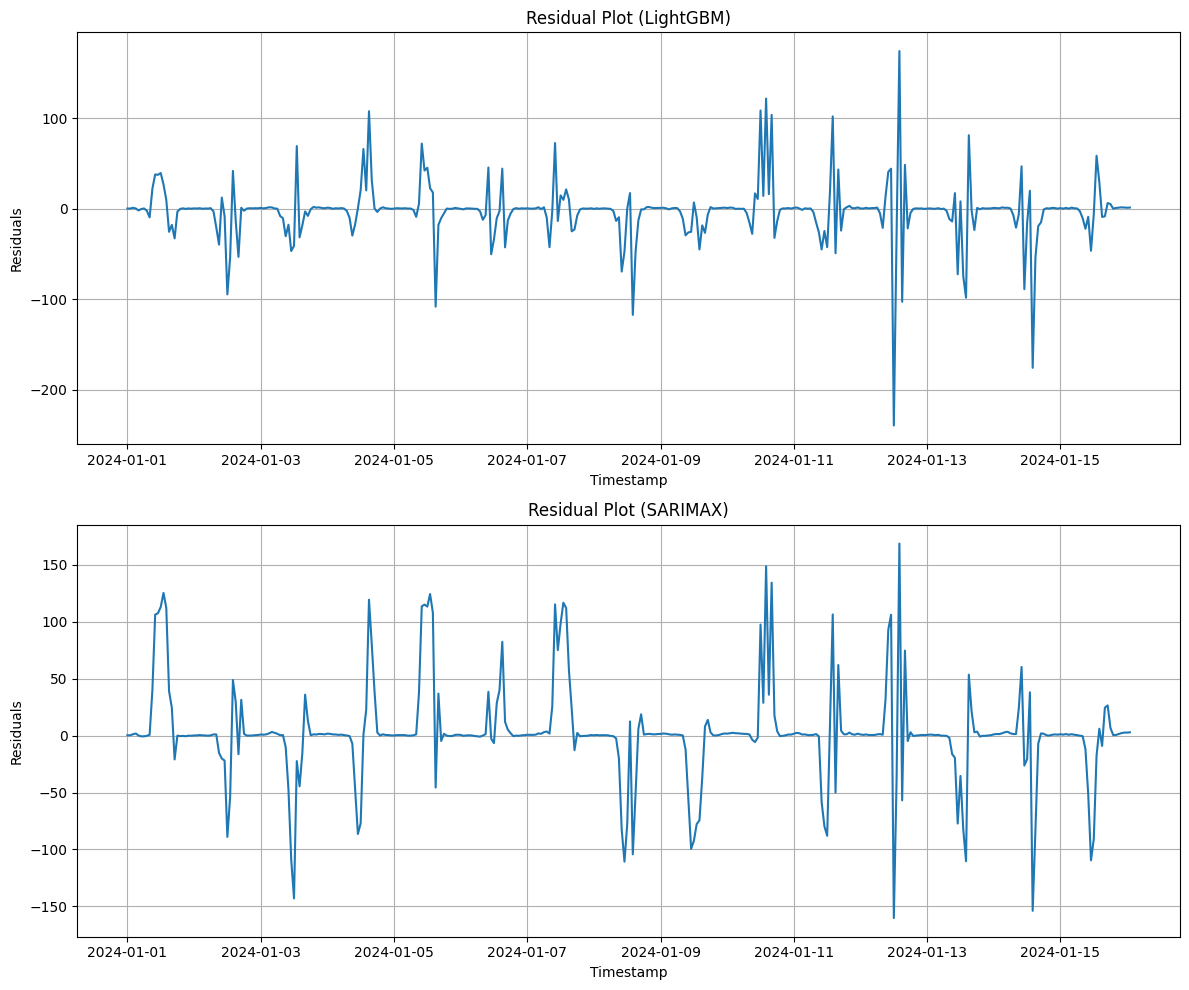

In [61]:
residuals_lgbm = data.iloc[len(y):]["actual_radiation"].values - best_model.predict(X_fore).flatten()
x_values_lgbm = data.iloc[len(y):].index
x_values_lgbm = x_values_lgbm[:len(residuals_lgbm)]
residuals_sarimax = data.iloc[len(y):]["actual_radiation"].values - y_pred_sarf.flatten()
x_values_sarimax = data.iloc[len(y):].index
x_values_sarimax = x_values_sarimax[:len(residuals_sarimax)]

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].plot(x_values_lgbm, residuals_lgbm) # changed to plot
axes[0].set_title(f"Residual Plot (LightGBM)")
axes[0].set_xlabel("Timestamp")
axes[0].set_ylabel("Residuals")
axes[0].grid(True)

axes[1].plot(x_values_sarimax, residuals_sarimax) # changed to plot
axes[1].set_title(f"Residual Plot (SARIMAX)")
axes[1].set_xlabel("Timestamp")
axes[1].set_ylabel("Residuals")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("residual_plot.pdf", format = "pdf")
plt.show()

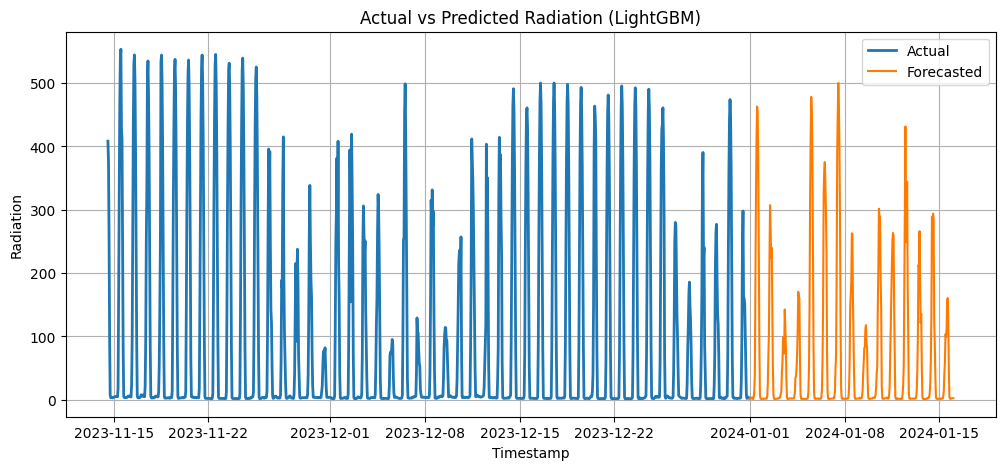

In [27]:
data_com['pred_radiation_lgb'] = np.nan
data_com.iloc[len(y):,2] = best_model.predict(X_fore)

n = 1500
plt.figure(figsize=(12, 5))
plt.plot(data_com['actual_radiation'].tail(n), label='Actual', linewidth=2)
plt.plot(data_com['pred_radiation_lgb'].tail(n), label='Forecasted', color='#ff7b00')
plt.title(f"Actual vs Predicted Radiation (LightGBM)")
plt.xlabel("Timestamp")
plt.ylabel("Radiation")
plt.legend()
plt.grid(True)
plt.savefig("final_pred_lgbm.pdf", format = "pdf")
plt.show()

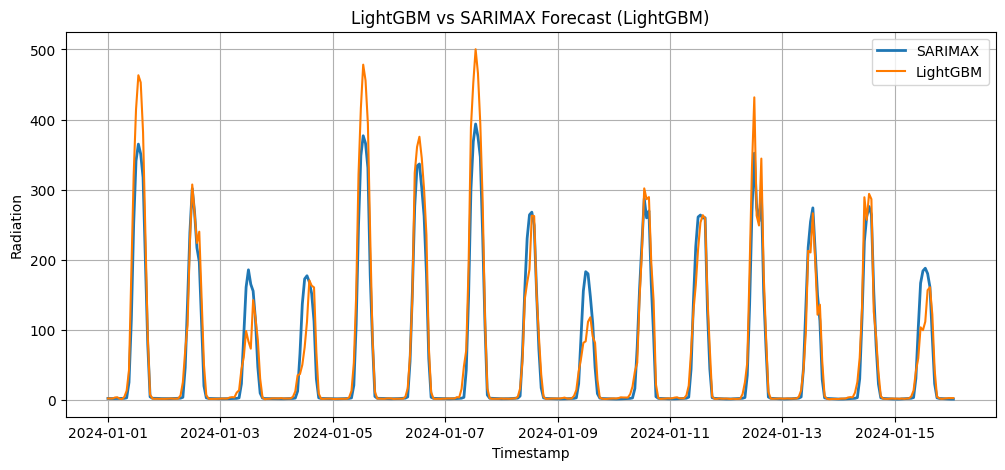

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(data_com.iloc[:,[1,2]].dropna()['pred_radiation_sar'], label='SARIMAX', linewidth=2)
plt.plot(data_com.iloc[:,[1,2]].dropna()['pred_radiation_lgb'], label='LightGBM', color='#ff7b00')
plt.title(f"LightGBM vs SARIMAX Forecast (LightGBM)")
plt.xlabel("Timestamp")
plt.ylabel("Radiation")
plt.legend()
plt.grid(True)
plt.savefig("final_pred_compare.pdf", format = "pdf")
plt.show()

# Data Creation

In [ ]:
df = pd.read_csv('data_forecast.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['timestamp'] = df['timestamp'].dt.tz_localize(None)

def assign_time_block(hour):
    if 21 <= hour or hour <= 5:
        return 1  # 9pm to 5am
    elif hour in [6, 20]:
        return 2  # 6am to 8pm
    elif hour in [7, 19]:
        return 3
    elif hour in [8, 18]:
        return 4
    elif hour in [9, 17]:
        return 5
    elif hour in [10, 16]:
        return 6
    elif hour in [11, 15]:
        return 7
    elif hour in [12, 13, 14]:
        return 8
df['timestamp'] = df['timestamp'].dt.tz_localize(None)

df['time_block'] = df['hour'].apply(assign_time_block)

# Add cyclical time features
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Encode month (for quarterly seasonality)
df['quarter'] = (df['month'] - 1) // 3 + 1
df['sin_quarter'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['cos_quarter'] = np.cos(2 * np.pi * df['quarter'] / 4)

df['lag_1'] = df['radiation'].shift(1)
df['rolling_mean_24'] = df['radiation'].rolling(24).mean()
df['radiation'] = df['radiation'].abs()

qt = QuantileTransformer(output_distribution='normal')
df['radiation_log'] = qt.fit_transform(df[['radiation']])
df = df.dropna()

# DM test

In [15]:
lgbm_pred = best_model.predict(X_test)
y_pred_sar = sarimax_train.predict(start=len(y_train), end=len(y) - 1, exog=X_test)
y_pred_sar = qt.inverse_transform(y_pred_sar.values.reshape(-1, 1))


In [20]:
from dieboldmariano import dm_test
import random

random.seed(123)
actual_lst = y_test
pred1_lst = lgbm_pred
pred2_lst = y_pred_sar

rt = dm_test(actual_lst,pred1_lst,pred2_lst, one_sided=True)
rt

(array([-26.48853212]), array([2.96795101e-147]))